In [ ]:
%%bash
pip install pandas-profiling

In [1]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import os
from glob import glob
import pandas as pd
from pandas_profiling import ProfileReport
import csv
import config

%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# Cloud Setup
This section is only required if running on cloud

In [ ]:
os.environ['BUCKET'] = config.BUCKET
os.environ['PROJECT'] = config.PROJECT
os.environ['REGION'] = config.REGION

In [ ]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

# Data Profiling
Data profiling is done to better understand the data, and to see if there are any invalid data (e.g. out of bounds data, unexpected data types). No data preprocessing should be done here; it should be done in tf.transform so as to have a consistent data pipeline.

In [2]:
files = glob('data/raw/spam*.csv')
df = pd.concat([pd.read_csv(f, usecols=config.RAW_DATA_COLS) for f in files], ignore_index=True)
df.columns = config.RENAMED_COLS
df

,spam,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


ZeroDivisionError: float division by zero

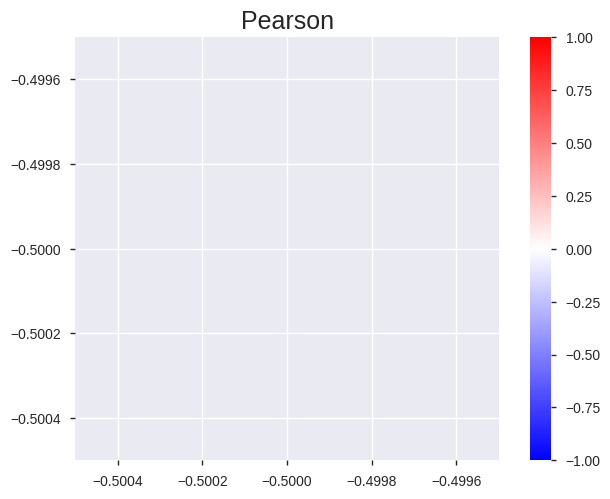

In [3]:
ProfileReport(df)

# Split Data
Example uses 80-10-10 split for train, eval and test - change if necessary

In [3]:
RANDOM_SEED = 42
train_df = df.sample(frac=0.8, random_state=RANDOM_SEED)
eval_df = df.drop(train_df.index)
test_df = eval_df.sample(frac=0.5, random_state=RANDOM_SEED)
eval_df = eval_df.drop(test_df.index)

In [4]:
def export_datasets(on_cloud=False):
    if on_cloud:
        data_dir = 'gs://{bucket}/spam-classification/data/split'.format(bucket=config.BUCKET)
    else:
        data_dir = 'data/split'
    
    if not os.path.exists('data'):
        os.mkdir('data')
    if not os.path.exists('data/split'):
        os.mkdir('data/split')
    
    # custom exporting code because single char delimiters may not be resilent to free text fields
    # which might contain delimiter characters
    def export_df(df, filename):
        full_path = os.path.join(data_dir, filename)
        csv_str = '\n'.join(config.DELIM.join(str(r) for r in rec) for rec in df.to_records(index=False))
        with open(full_path, 'w') as f:
            f.write(csv_str)
    
    export_df(train_df, 'train.csv')
    export_df(eval_df, 'eval.csv')
    export_df(test_df, 'test.csv')
    
    # required if we want to feed the raw labels into the model 
    # (and get back the text labels instead of integers when serving)
    label_vocab = list(df[config.LABEL_COL].unique())
    n_classes = len(label_vocab)
    
    if not os.path.exists('data/misc'):
        os.mkdir('data/misc')
    
    # keras doesn't support the label_vocabulary argument like canned estimators in tf.estimator,
    # so we have to reverse engineer the vocab lookup
    with open('./data/misc/labels.txt', 'w') as f:
        f.write('\n'.join(label_vocab))
    with open('variables.py', 'w') as f:
        f.write(
"""
import tensorflow as tf


LABEL_TO_INDEX = tf.contrib.lookup.index_table_from_file(
    './data/misc/labels.txt',
    default_value=-1,
    num_oov_buckets=1
)

INDEX_TO_LABEL = tf.contrib.lookup.index_to_string_table_from_file(
    './data/misc/labels.txt',
    default_value='ham'
)

N_CLASSES = {n_classes}
LABEL_VOCABULARY = {label_vocab}

""".format(n_classes=n_classes, label_vocab=label_vocab))
        
    return
  
export_datasets(on_cloud=False)